In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim


In [2]:
true_b = 1
true_w = 2
N = 100

# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

# Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:int(N*.8)]
# Uses the remaining indices for validation
val_idx = idx[int(N*.8):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]


In [3]:
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Building the model from the figure above
model = nn.Sequential(nn.Linear(3, 5), nn.Linear(5, 1)).to(device)
model


Sequential(
  (0): Linear(in_features=3, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [5]:
%%writefile data_preparation/v0.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors and then send 
# them to the chosen device
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)


Overwriting data_preparation/v0.py


In [6]:
%run -i data_preparation/v0.py

In [7]:
%%writefile model_configuration/v0.py

# This is redundant now, but it won't be when we introduce
# Datasets...
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1
torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines an SGD optimizer to update the parameters(now retrieved directly from the model)
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

Overwriting model_configuration/v0.py


In [8]:
%run -i model_configuration/v0.py

In [9]:
%%writefile model_training/v0.py
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Sets model to TRAIN mode
    model.train()
    # Step 1 - Computes model's predicted output - forward pass
    yhat = model(x_train_tensor)
    
    # Step 2 - Computes the loss
    loss = loss_fn(yhat, y_train_tensor)
    
    # Step 3 - Computes gradients for both "b" and "w" parameters
    loss.backward()
    
    # Step 4 - Updates parameters using gradients and
    # the learning rate
    optimizer.step()
    optimizer.zero_grad()

Overwriting model_training/v0.py


In [10]:
%run -i model_training/v0.py

In [11]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


In [12]:
%run -i data_preparation/v0.py
%run -i model_configuration/v0.py
%run -i model_training/v0.py

In [13]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


## higher order function

In [14]:
def exponentiation_builder(exponent):
    def skeleton_exponentiation(x):
        return x ** exponent
    return skeleton_exponentiation


returned_function = exponentiation_builder(4)
returned_function(5)

625

In [15]:
def cal_area(F):
    def rect(L):
        return (L**2)*F
    return rect   

Area = cal_area(1)
Area(5)

25

In [16]:
def Find_area(A):
    def area(*L):
        if A == 'rec': 
            return (L[0]*L[1])
        if A == 'sq': 
            return (L[0]**2)

        if A == 'circ': 
            import math
            return math.pi*(L[0]**2)
    return area   

Find_area('rec')(10,2)  



20

In [17]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()
        
        # Step 1 - Computes model's predictions - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients for "b" and "w" parameters
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn


In [18]:
%%writefile model_configuration/v1.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines an SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

Overwriting model_configuration/v1.py


In [19]:
%run -i model_configuration/v1.py

In [20]:
train_step_fn

<function __main__.make_train_step_fn.<locals>.perform_train_step_fn(x, y)>

In [21]:
%%writefile model_training/v1.py

# Defines number of epochs
n_epochs = 1000

losses = [] 

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step_fn(x_train_tensor, y_train_tensor) 
    losses.append(loss)

Overwriting model_training/v1.py


In [22]:
%run -i model_training/v1.py

In [23]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9690]], device='cuda:0')), ('0.bias', tensor([1.0235], device='cuda:0'))])


In [24]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor
    def __getitem__(self, index):
        return (self.x[index], self.y[index])
    def __len__(self):
        return len(self.x)
        
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()
train_data = CustomDataset(x_train_tensor, y_train_tensor)
print(train_data[0])

(tensor([0.7713]), tensor([2.4745]))


In [25]:
from torch.utils.data import DataLoader
train_loader = DataLoader(
dataset=train_data,
batch_size=16,
shuffle=True,
)

In [26]:
#next(iter(train_loader))

In [27]:
#list(train_loader)

In [28]:
a = ['foo', 'bar', 'baz']

itr = iter(a)
next(itr)
next(itr)

'bar'

In [29]:
%%writefile data_preparation/v1.py
from torch.utils.data import TensorDataset

# Our data was in Numpy arrays, but we need to transform them
# into PyTorch's Tensors
x_train_tensor = torch.as_tensor(x_train).float()
y_train_tensor = torch.as_tensor(y_train).float()

# Builds Dataset
train_data = TensorDataset(x_train_tensor, y_train_tensor)

# Builds DataLoader
train_loader = DataLoader(
dataset=train_data,
batch_size=16,
shuffle=True )

Overwriting data_preparation/v1.py


In [30]:
%run -i data_preparation/v1.py

In [31]:
%%writefile model_training/v2.py

# Defines number of epochs
n_epochs = 1000

losses = []

# For each epoch...
for epoch in range(n_epochs):
    # inner loop
    mini_batch_losses = [] 
    for x_batch, y_batch in train_loader:
        # the dataset "lives" in the CPU, so do our mini-batches
        # therefore, we need to send those mini-batches to the
        # device where the model "lives"
        x_batch = x_batch.to(device) 
        y_batch = y_batch.to(device)
        
        # Performs one train step and returns the
        # corresponding loss for this mini-batch
        mini_batch_loss = train_step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)
    
    # Computes average loss over all mini-batches
    # That's the epoch loss
    loss = np.mean(mini_batch_losses) 
    
    losses.append(loss)

Overwriting model_training/v2.py


In [32]:
%run -i model_training/v2.py

In [33]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9696]], device='cuda:0')), ('0.bias', tensor([1.0243], device='cuda:0'))])


In [34]:
def mini_batch(device, data_loader, step_fn):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)
    loss = np.mean(mini_batch_losses)
    return loss


In [35]:
%run -i data_preparation/v1.py
%run -i model_configuration/v1.py

In [36]:
%%writefile model_training/v3.py

# Defines number of epochs
n_epochs = 200

losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)

Overwriting model_training/v3.py


In [37]:
%run -i model_training/v3.py

In [38]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9684]], device='cuda:0')), ('0.bias', tensor([1.0219], device='cuda:0'))])


In [39]:
%%writefile data_preparation/v2.py
from torch.utils.data.dataset import random_split
torch.manual_seed(13)

# Builds tensors from numpy arrays BEFORE split
x_tensor = torch.as_tensor(x).float() 
y_tensor = torch.as_tensor(y).float() 

# Builds dataset containing ALL data points
dataset = TensorDataset(x_tensor, y_tensor)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train
train_data, val_data = random_split(dataset, [n_train, n_val]) 

# Builds a loader of each set
train_loader = DataLoader( dataset=train_data,
                           batch_size=16,
                           shuffle=True,
                            )
val_loader = DataLoader(dataset=val_data, batch_size=16) 

Overwriting data_preparation/v2.py


In [40]:
%run -i data_preparation/v2.py

In [41]:
#Helper Function #3

def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()
        
        # Step 1 - Computes our model's predicted output: forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

In [42]:
%%writefile model_configuration/v2.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines an SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model, loss function
# and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn) 

Overwriting model_configuration/v2.py


In [43]:
%run -i model_configuration/v2.py

In [44]:
%%writefile model_training/v4.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = [] 

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION - no gradients in validation!
    with torch.no_grad(): 
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)

Overwriting model_training/v4.py


In [45]:
%run -i model_training/v4.py

In [46]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9438]], device='cuda:0')), ('0.bias', tensor([1.0287], device='cuda:0'))])


In [47]:
%run -i data_preparation/v2.py
%run -i model_configuration/v2.py
%run -i model_training/v4.py

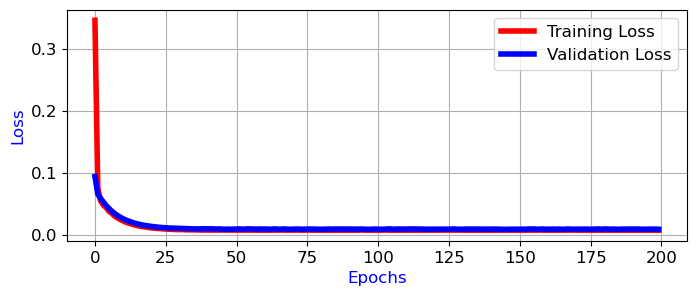

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize =(8, 3),)
plt.rc('font', size=12)
plt.plot(range(200), losses , linewidth=4.0, color='r', label = 'Training Loss')  
plt.plot(range(200), val_losses, linewidth=4.0 , color='b', label = 'Validation Loss')
plt.ylabel('Loss',  color='blue')
plt.xlabel('Epochs', color='blue')
plt.legend()
plt.grid(True)  
plt.show()

## Tensorboard


In [61]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [66]:
#%tensorboard --logdir runs

In [112]:
import tensorflow as tf
import datetime, os

logs_base_dir = "./runs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(logs_base_dir, exist_ok = True)
%tensorboard --logdir {logs_base_dir}

In [67]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/test')


In [72]:
# Fetching a tuple of feature (dummy_x) and label (dummy_y)
dummy_x, dummy_y = next(iter(train_loader))
# Since our model was sent to device, we need to do the same with the data.
# Even here, both model and data need to be on the same device!
writer.add_graph(model, dummy_x.to(device), verbose=False)


In [73]:
writer.add_scalars(
main_tag='loss',
tag_scalar_dict={'training': loss,  'validation': val_loss},
global_step=epoch
)

In [82]:
%%writefile model_configuration/v3.py

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Sets learning rate - this is "eta" ~ the "n"-like Greek letter
lr = 0.1

torch.manual_seed(42)
# Now we can create a model and send it at once to the device
model = nn.Sequential(nn.Linear(1, 1)).to(device)

# Defines an SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines an MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

# Creates the train_step function for our model,
# loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

# Creates a Summary Writer to interface with TensorBoard
writer = SummaryWriter('runs/simple_linear_regression') 
# Fetches a single mini-batch so we can use add_graph
x_dummy, y_dummy = next(iter(train_loader))
writer.add_graph(model, x_dummy.to(device))

Writing model_configuration/v3.py


In [85]:
%%writefile model_training/v5.py

# Defines number of epochs
n_epochs = 200

losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn)
    losses.append(loss)
    
    # VALIDATION - no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    
    # Records both losses for each epoch under tag "loss"
    writer.add_scalars(
        main_tag='loss', 
        tag_scalar_dict={ 'training': loss, 'validation': val_loss},
        global_step=epoch)

# Closes the writer
writer.close()

Overwriting model_training/v5.py


In [86]:
%run -i data_preparation/v2.py
%run -i model_configuration/v3.py
%run -i model_training/v5.py


In [87]:
# Checks model's parameters
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


In [88]:
checkpoint = {  'epoch': n_epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': losses,
                'val_loss': val_losses}
torch.save(checkpoint, 'model_checkpoint.pth')

In [113]:
%run -i data_preparation/v2.py
%run -i model_configuration/v3.py

In [114]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]], device='cuda:0')), ('0.bias', tensor([0.8300], device='cuda:0'))])


In [115]:
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
saved_epoch = checkpoint['epoch']
saved_losses = checkpoint['loss']
saved_val_losses = checkpoint['val_loss']

# Never forget to set the mode!
model.train() # always use TRAIN for resuming training

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [116]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


In [111]:
%run -i model_training/v5.py

In [97]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.9411]], device='cuda:0')), ('0.bias', tensor([1.0230], device='cuda:0'))])


In [108]:
import tensorflow as tf
import datetime, os

logs_base_dir = "./runs"
os.makedirs(logs_base_dir, exist_ok = True)
%tensorboard --logdir {logs_base_dir}

Reusing TensorBoard on port 6006 (pid 11884), started 1 day, 8:35:30 ago. (Use '!kill 11884' to kill it.)

In [101]:
datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

'20240223-215553'

In [107]:
import shutil
shutil.rmtree(logs_base_dir, ignore_errors=True)

In [118]:
from datetime import datetime
now = datetime.now()
now.strftime("%Y%m%d-%H%M%S")

'20240223-222717'

In [120]:
#!taskkill /F /PID 11884

SUCCESS: The process with PID 11884 has been terminated.


In [121]:
%run -i model_configuration/v3.py

In [122]:
checkpoint = torch.load('model_checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(model.state_dict())


OrderedDict([('0.weight', tensor([[1.9432]], device='cuda:0')), ('0.bias', tensor([1.0263], device='cuda:0'))])


In [123]:
new_inputs = torch.tensor([[.20], [.34], [.57]])
model.eval() # always use EVAL for fully trained models!
model(new_inputs.to(device))

tensor([[1.4150],
        [1.6870],
        [2.1340]], device='cuda:0', grad_fn=<AddmmBackward0>)